In [1]:
import pandas as pd
import glob
import seaborn as sns
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import LogNorm


files_path = '../data/for_tests/'


def load_data(path):
    with open(path, 'r') as JSON:
        json_dict = json.load(JSON)
    return json.loads(json_dict)   
    

def name_change(name):
    er = name.split('ER')
    he = name.split('He')
    if len(er) > 1:
        return ['ER', er[-1].split('_')[1]]
    elif len(he) > 1:
        return ['He', he[-1].split('_')[1]]
    else:
        return None
    
    
def get_f1_data_from_raw(input_dict):
    x = np.array(input_dict['ROC']['full'])[:, 0, :, :]
    y = np.array(input_dict['ROC']['full'])[:, 1, :, :]
    f1 = (2*x*y)/(x+y)
    f1 = np.nan_to_num(f1)
    result = f1.max(axis=1).ravel()
    n_filters = x.shape[-1]
    table = pd.DataFrame({'path':list(itertools.chain.from_iterable(itertools.repeat(x, n_filters) for x in input_dict['Image_path'])),
                          'image':list(itertools.chain.from_iterable(itertools.repeat(x, n_filters) for x in input_dict['Image_index'])),
                      'filter':input_dict['Filter_name'],
                      'parameter': input_dict['Filter_parameter'],
                      'f1': result})
    table = pd.DataFrame.from_records(table.path.apply(name_change), columns=['particle', 'energy']).join(table.drop('path', axis=1))
    table['parameter'] = table.parameter.apply(lambda x: x[0])
    table.energy = table.energy.astype(np.int)
    table.parameter[table.parameter == 'n'] = 0
    table.parameter = table.parameter.astype(np.int)
    return table

## TODO : merge those functions
def get_data_from_raw(input_dict):
    x = np.array(input_dict['ROC']['full'])[:, 0, :, :]
    y = np.array(input_dict['ROC']['full'])[:, 1, :, :]
    energy = np.array(input_dict['Energy']['image_after_threshold'])
    n_filters = x.shape[2]
    table = pd.DataFrame({'path':list(itertools.chain.from_iterable(itertools.repeat(x, n_filters) for x in input_dict['Image_path'])),
                          'image':list(itertools.chain.from_iterable(itertools.repeat(x, n_filters) for x in input_dict['Image_index'])),
                          'filter':input_dict['Filter_name'],
                          'parameter': input_dict['Filter_parameter']})
    table['recall'] = np.hstack(x).T.tolist()
    table['precision'] = np.hstack(y).T.tolist()
    table['energy_threshold'] = np.hstack(energy).T.tolist()
    table = pd.DataFrame.from_records(table.path.apply(name_change), columns=['particle', 'energy']).join(table.drop('path', axis=1))
    table['parameter'] = table.parameter.apply(lambda x: x[0])
    table.energy = table.energy.astype(np.int)
    table.parameter[table.parameter == 'n'] = 0
    table.parameter = table.parameter.astype(np.int)
    return table

def fill_nan_nn(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

## Carregando resultados

In [2]:
files = glob.glob(files_path + '*.json')

In [3]:
result_table = []
for file in files:
    result_table.append(get_f1_data_from_raw(load_data(file)))
result_table = pd.concat(result_table)

In [4]:
result_table.head(-2)

,particle,energy,image,filter,parameter,f1
0,He,30,pic_run1_ev8,gaussian,3,0.627138
1,He,30,pic_run1_ev8,gaussian,7,0.863841
2,He,30,pic_run1_ev8,gaussian,9,0.894204
3,He,30,pic_run1_ev8,gaussian,11,0.912127
4,He,30,pic_run1_ev8,gaussian,13,0.910995
...,...,...,...,...,...,...
2333,He,10,pic_run1_ev76,gaussian,9,0.877434
2334,He,10,pic_run1_ev76,gaussian,11,0.892617
2335,He,10,pic_run1_ev76,gaussian,13,0.893665
2336,He,10,pic_run1_ev76,gaussian,17,0.895152


## Análise dos resultados
  * Desempenho dos filtros para cada tipo de partícula e valor de energia
  * Reconstrução da curva energia x integral dos clusters

### Análise por valor de Energia

Text(0.5, 1.0, 'Nuclear recoil')

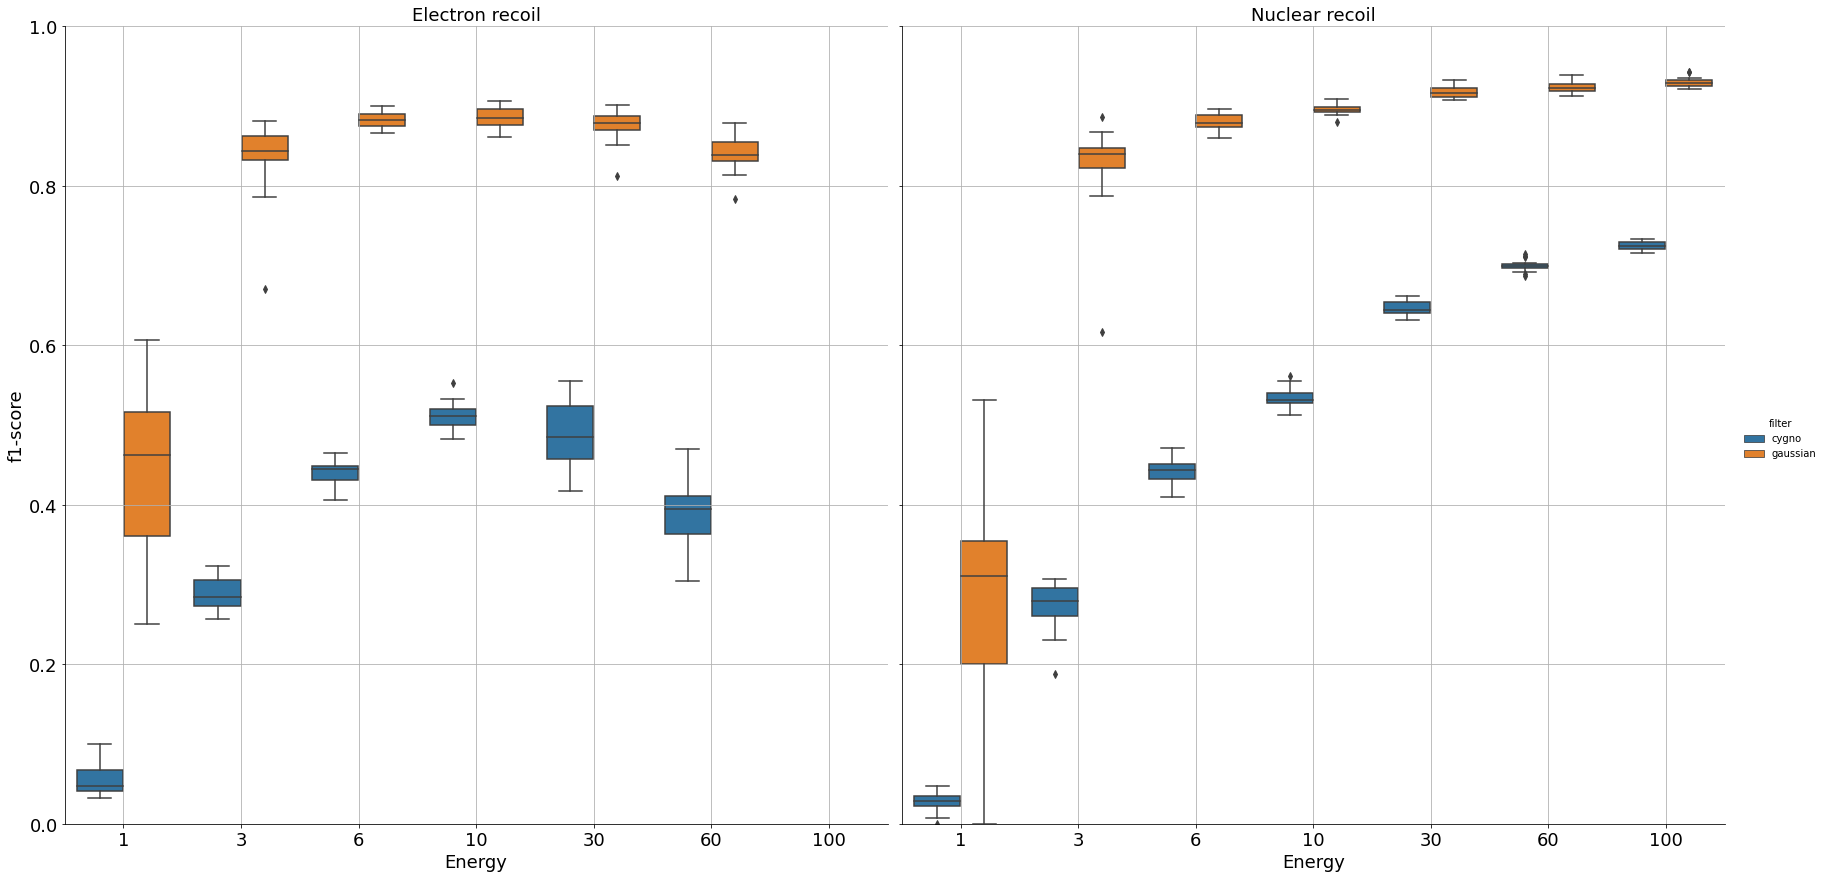

In [5]:
#plt.figure(figsize=(30,15))
g = sns.catplot(x="energy", y="f1", hue="filter", col="particle", data=result_table.groupby(['particle','filter', 'energy', 'image']).agg({'f1':'max'}).reset_index(), kind="box", height=12, aspect=1)
axes = g.axes.ravel()
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel('Energy', fontsize=18)
axes[0].set_ylabel('f1-score', fontsize=18)
axes[1].set_xlabel('Energy', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])
axes[0].set_title('Electron recoil', fontsize=18)
axes[1].set_title('Nuclear recoil', fontsize=18)

Text(0.5, 1.0, 'Nuclear recoil')

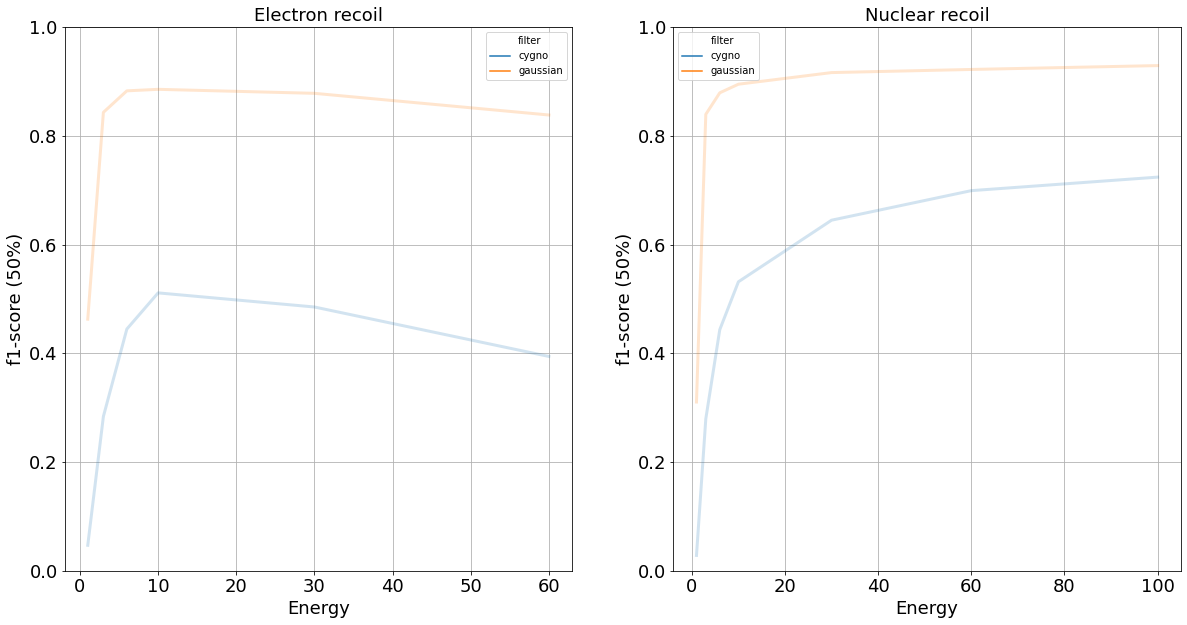

In [6]:
only_median = result_table.groupby(['particle','filter', 'energy', 'image']).agg({'f1':'max'}).groupby(['particle', 'filter', 'energy']).agg('median').reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x='energy', 
             y='f1',
             hue='filter',
             lw=3,
             #col = 'particle',
             #palette=['b','r'],
             data=only_median[only_median['particle']=='ER'],
             alpha = 0.2,
             ax = ax[0])
sns.lineplot(x='energy', 
             y='f1',
             hue='filter',
             lw=3,
             #col = 'particle',
             #palette=['b','r'],
             data=only_median[only_median['particle']=='He'],
             alpha = 0.2,
             ax = ax[1])

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Energy', fontsize=18)
ax[0].set_ylabel('f1-score (50%)', fontsize=18)
ax[1].set_ylabel('f1-score (50%)', fontsize=18)
ax[1].set_xlabel('Energy', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])
ax[0].set_title('Electron recoil', fontsize=18)
ax[1].set_title('Nuclear recoil', fontsize=18)
#ax[0].get_legend().remove()
#ax[1].get_legend().remove()

### Estimação de energia

#### Energia perdida após inserção e remoção do pedestal

In [7]:
teste = []
for file in files:
    d = load_data(file)
    data_frame_teste = pd.DataFrame([d['Image_path'], d['Image_index'], d['Energy']['image_truth'], d['Energy']['image_real']]).T
    teste.append(data_frame_teste)
energy_df = pd.concat(teste)
energy_df.columns = ['image_path', 'image_index', 'energy_truth', 'energy_real']

In [8]:
energy_df = pd.DataFrame.from_records(energy_df.image_path.apply(name_change).values, columns = ['particle', 'energy']).join(energy_df.reset_index().drop(['index', 'image_path', 'image_index'], axis=1))

In [9]:
energy_df.head()

,particle,energy,energy_truth,energy_real
0,He,30,14927,14976.6
1,He,30,14869,14869.9
2,He,30,14816,14574.9
3,He,30,14888,14909.3
4,He,30,14926,15013.8


In [10]:
energy_df[["energy", "energy_truth", "energy_real"]] = energy_df[["energy", "energy_truth", "energy_real"]].apply(pd.to_numeric)

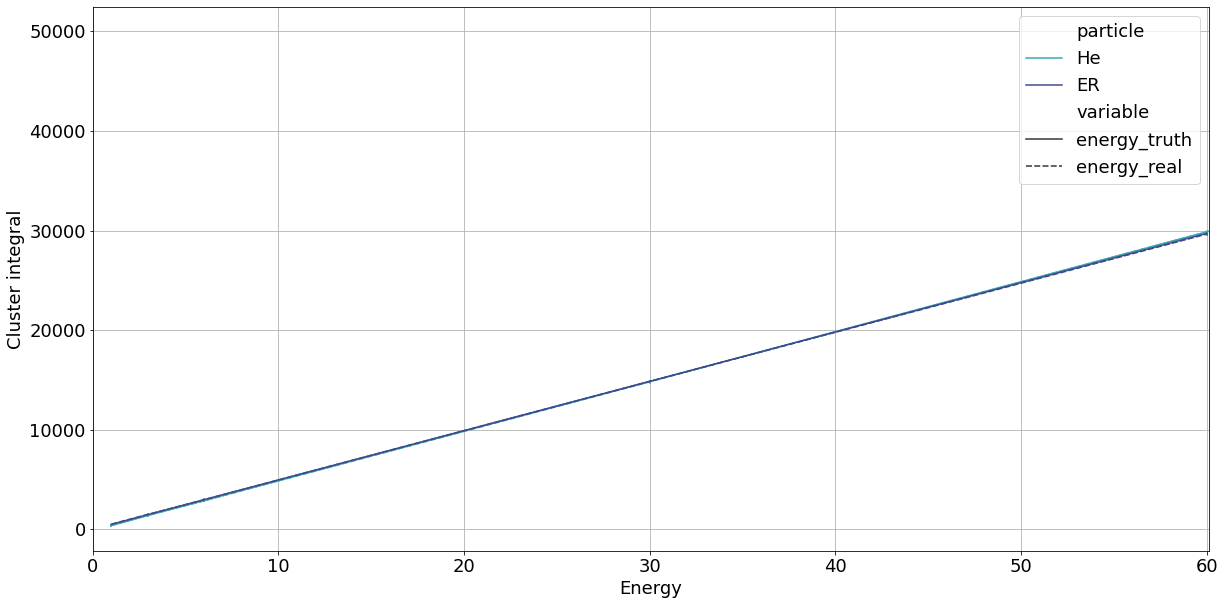

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
palette = sns.color_palette("mako_r", 2)
sns.lineplot(x="energy", y="value", hue="particle", data=pd.melt(energy_df, id_vars=['particle', 'energy']),  err_style="bars", style="variable",  palette=palette, ax=axes)
axes.grid()
axes.set_ylabel('Cluster integral', fontsize=18)
axes.set_xlabel('Energy', fontsize=18)
axes.set_xlim([0, 60.1])
axes.tick_params(axis='both', which='major', labelsize=18)
axes.legend(fontsize=18)

#### Energia após filtragem
    * No caso anterior temos uma rejeição de background de 100% e detecção de sinal de 100%. Assumi-se uma clusterização perfeita e o erro exibido é o de estimação de pedestal;
    * Com a filtragem (ou ausência desta) pixels podem ser classificados de maneira incorreta ( pixels de sinal podem ser considerados background e vice-versa)
    
    * Escolhendo os melhores filtros para cada particula e energia

In [12]:
agg_results = result_table.groupby(['particle', 'energy', 'filter', 'parameter']).agg('median')

In [13]:
agg_results = agg_results.reset_index()

In [14]:
agg_results

,particle,energy,filter,parameter,f1
0,ER,1,cygno,0,0.046946
1,ER,1,gaussian,3,0.010879
2,ER,1,gaussian,7,0.407151
3,ER,1,gaussian,9,0.444492
4,ER,1,gaussian,11,0.460309
...,...,...,...,...,...
112,He,100,gaussian,11,0.926529
113,He,100,gaussian,13,0.927992
114,He,100,gaussian,17,0.927046
115,He,100,gaussian,21,0.926091


In [15]:
agg_results = agg_results.sort_values('f1').drop_duplicates(subset=['particle', 'filter', 'energy'], keep='last')

In [16]:
agg_results.drop('f1',axis=1, inplace=True)

In [17]:
agg_results

,particle,energy,filter,parameter
54,He,1,cygno,0
0,ER,1,cygno,0
63,He,3,cygno,0
9,ER,3,cygno,0
58,He,1,gaussian,11
45,ER,60,cygno,0
72,He,6,cygno,0
18,ER,6,cygno,0
4,ER,1,gaussian,11
36,ER,30,cygno,0


In [18]:
full_result_table = []
for file in files:
    full_result_table.append(get_data_from_raw(load_data(file)))
full_result_table = pd.concat(full_result_table)

In [19]:
full_result_table

,particle,energy,image,filter,parameter,recall,precision,energy_threshold
0,He,30,pic_run1_ev8,gaussian,3,"[0.9982425307557118, 0.9929701230228472, 0.963...","[0.00013725711471529177, 0.0001488558256242262...","[14979.867435617234, 14980.036595572808, 14981..."
1,He,30,pic_run1_ev8,gaussian,7,"[0.9982425307557118, 0.9982425307557118, 0.978...","[0.00013925585885928368, 0.0005220717793548186...","[14979.867435617234, 14979.867435617234, 14975..."
2,He,30,pic_run1_ev8,gaussian,9,"[0.9982425307557118, 0.9947275922671354, 0.985...","[0.00023292759642505348, 0.014671574472497279,...","[14979.867435617234, 14982.300182889132, 14974..."
3,He,30,pic_run1_ev8,gaussian,11,"[0.9982425307557118, 0.9929701230228472, 0.991...","[0.04499722728353006, 0.4172821270310192, 0.59...","[14979.867435617234, 14982.69047131154, 14980...."
4,He,30,pic_run1_ev8,gaussian,13,"[0.9982425307557118, 0.9964850615114236, 0.992...","[0.5414680648236415, 0.6025504782146652, 0.636...","[14974.730315829383, 14979.071679022672, 14982..."
...,...,...,...,...,...,...,...,...
2335,He,10,pic_run1_ev76,gaussian,13,"[0.9977272727272727, 0.9977272727272727, 0.997...","[0.010289705606600412, 0.05153791969945997, 0....","[4845.591453883571, 4845.591453883571, 4845.59..."
2336,He,10,pic_run1_ev76,gaussian,17,"[0.9977272727272727, 0.9977272727272727, 0.997...","[0.31537356321839083, 0.3673640167364017, 0.40...","[4845.591453883571, 4845.591453883571, 4845.59..."
2337,He,10,pic_run1_ev76,gaussian,21,"[0.9977272727272727, 0.9977272727272727, 0.997...","[0.40573012939001846, 0.4291300097751711, 0.44...","[4845.591453883571, 4845.591453883571, 4845.59..."
2338,He,10,pic_run1_ev76,gaussian,23,"[0.9977272727272727, 0.9977272727272727, 0.997...","[0.00010479492897577399, 0.0001048083392103992...","[4868.817354742594, 4868.817354742594, 4868.81..."


In [77]:
filtered_full_result_table = agg_results.merge(full_result_table, how='inner', left_on=['particle', 'energy', 'filter','parameter'], right_on=['particle', 'energy', 'filter','parameter'])

In [78]:
precision_matrix = np.array(filtered_full_result_table['precision'].tolist())
recall_matrix = np.array(filtered_full_result_table['recall'].tolist())
energy_matrix = np.array(filtered_full_result_table['energy_threshold'].tolist())
precision_matrix = fill_nan_nn(precision_matrix)
recall_matrix = fill_nan_nn(recall_matrix)
energy_matrix = fill_nan_nn(energy_matrix)

In [79]:
xx, yy = np.where(precision_matrix>0.2)
position_array = np.array([xx,yy]).T
list_of_valid_index = np.split(position_array[:, 1], np.cumsum(np.unique(position_array[:, 0], return_counts=True)[1])[:-1])

In [80]:
best_recall = []
for index, count in list(enumerate(np.unique(position_array[:, 0]))):
    best_recall.append([count, max(recall_matrix[count,list_of_valid_index[index]]), max(energy_matrix[count,list_of_valid_index[index]])])

In [81]:
p_results = pd.DataFrame(np.array(best_recall), columns=['index', 'recall_at_p', 'energy_at_p'])
p_results.index = p_results['index'].astype(int)
p_results.drop(['index'], axis=1, inplace=True)

In [82]:
filtered_full_result_table = filtered_full_result_table.join(p_results)

In [83]:
filtered_full_result_table.head()

,particle,energy,filter,parameter,image,recall,precision,energy_threshold,recall_at_p,energy_at_p
0,He,1,cygno,0,pic_run1_ev3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5.054473876953125e-05, 5.054473876953125e-05,...","[469.75799615477945, 469.75799615477945, 469.7...",0.009434,15.556388
1,He,1,cygno,0,pic_run1_ev5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.553794860839844e-05, 4.553794860839844e-05,...","[432.6624887950684, 432.6624887950684, 432.662...",0.015707,25.493225
2,He,1,cygno,0,pic_run1_ev43,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.5299530029296875e-05, 4.5299530029296875e-0...","[467.2614484520617, 467.2614484520617, 467.261...",0.015789,27.636687
3,He,1,cygno,0,pic_run1_ev83,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.696846008300781e-05, 4.696846008300781e-05,...","[466.3739215997964, 466.3739215997964, 466.373...",0.020305,34.273127
4,He,1,cygno,0,pic_run1_ev50,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.3392181396484375e-05, 4.3392181396484375e-0...","[345.4617465629766, 345.4617465629766, 345.461...",NaN,NaN


In [89]:
energy_filters_result = filtered_full_result_table[['particle', 'energy', 'filter', 'energy_at_p']]

In [85]:
energy_concat = pd.melt(energy_df, id_vars=['particle', 'energy'])
energy_concat.columns = ['particle', 'energy', 'filter', 'energy_at_p']
energy_concat

,particle,energy,filter,energy_at_p
0,He,30,energy_truth,14927.000000
1,He,30,energy_truth,14869.000000
2,He,30,energy_truth,14816.000000
3,He,30,energy_truth,14888.000000
4,He,30,energy_truth,14926.000000
...,...,...,...,...
515,He,10,energy_real,4874.470722
516,He,10,energy_real,4935.751832
517,He,10,energy_real,4895.303549
518,He,10,energy_real,4958.722715


In [86]:
filt = ['gaussian', 'energy_real', 'cygno']
data = energy_filters_result.append(energy_concat)
#data = energy_filters_result[energy_filters_result['filter'].isin(filt)]
data = data[data['filter'].isin(filt)]

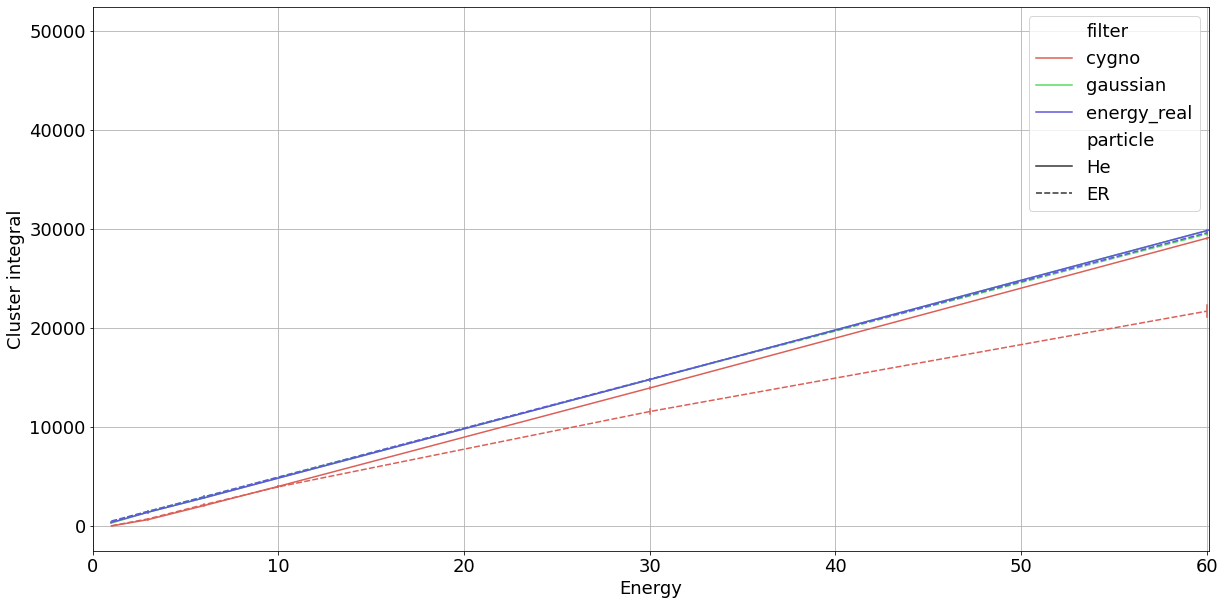

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
palette = sns.color_palette("hls", len(filt))
sns.lineplot(x="energy", y="energy_at_p", hue="filter", data=data,  err_style="bars", style="particle",  palette=palette, ax=axes)
axes.grid()
axes.set_ylabel('Cluster integral', fontsize=18)
axes.set_xlabel('Energy', fontsize=18)
axes.set_xlim([0, 60.1])
axes.tick_params(axis='both', which='major', labelsize=18)
axes.legend(fontsize=18)

Text(0.5, 1.0, 'Electron recoil')

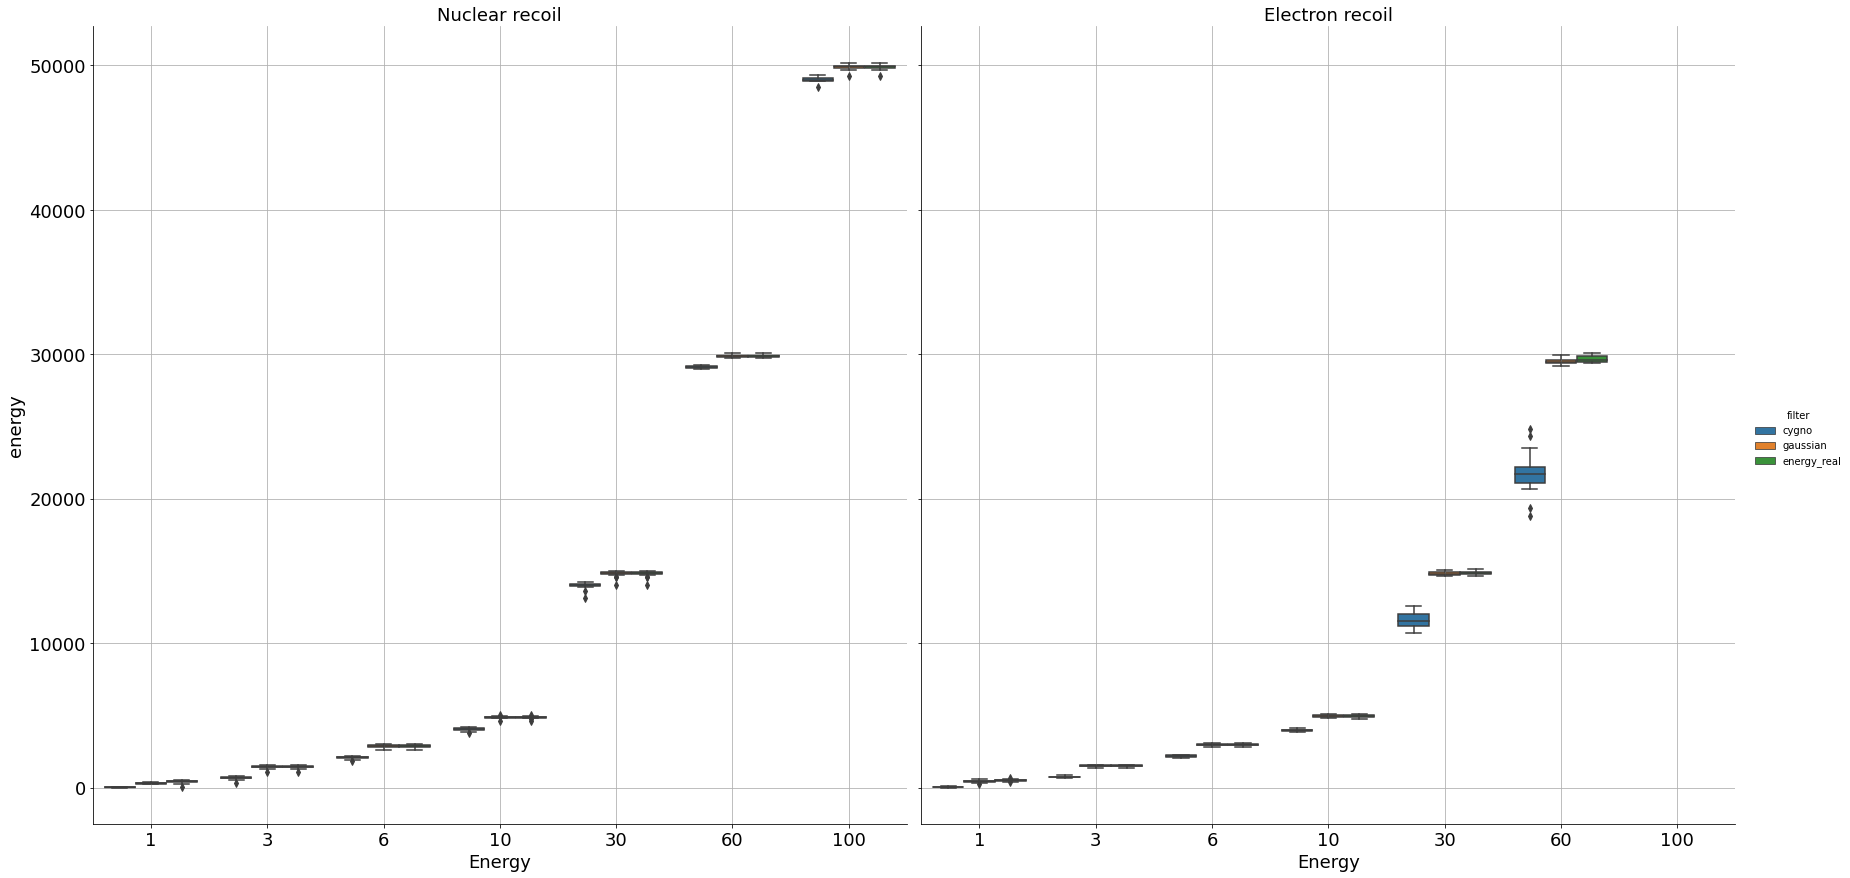

In [88]:
#plt.figure(figsize=(30,15))
g = sns.catplot(x="energy", y="energy_at_p", hue="filter", col="particle", data=data, kind="box", height=12, aspect=1)
axes = g.axes.ravel()
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel('Energy', fontsize=18)
axes[0].set_ylabel('energy', fontsize=18)
axes[1].set_xlabel('Energy', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[0].set_title('Nuclear recoil', fontsize=18)
axes[1].set_title('Electron recoil', fontsize=18)